In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    outputs = pickle.load(fp)

In [3]:
# Sanity check
print(inputs.shape)
print(outputs.shape)

(25650, 4, 32, 32)
(25650, 1, 32, 32)


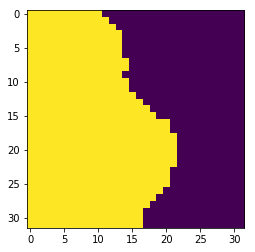

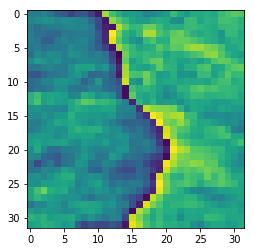

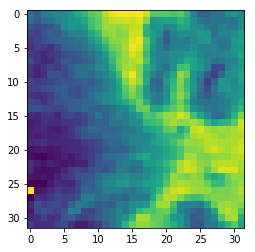

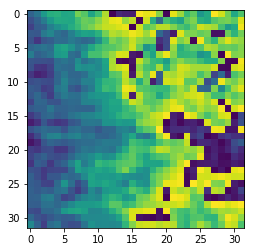

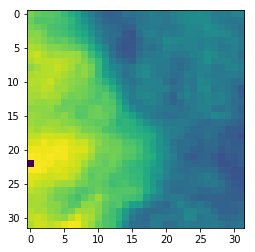

In [5]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
    cropped_t1_img = inputs[idx,1,:,:]
    plt.imshow(cropped_t1_img)
    plt.show()
    cropped_t1ce_img = inputs[idx,2,:,:]
    plt.imshow(cropped_t1ce_img)
    plt.show()
    cropped_t2_img = inputs[idx,3,:,:]
    plt.imshow(cropped_t2_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*75/100)
val_cutoff = int(inputs.shape[0]*95/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

19237
19237
5130
5130
1283
1283


In [8]:
train_inputs = np.asarray(train_inputs)
val_inputs = np.asarray(val_inputs)
test_inputs = np.asarray(test_inputs)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [27]:
train_outputs = np.asarray(train_outputs)
n_tumor_pixels = np.count_nonzero(train_outputs)
n_tumor1 = np.count_nonzero(train_outputs==1)
n_tumor2 = np.count_nonzero(train_outputs==2)
n_tumor3 = np.count_nonzero(train_outputs==3)
n_tumor4 = np.count_nonzero(train_outputs==4)
total_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
print(total_pixels)
n_blank_pixels = total_pixels - n_tumor_pixels
frac_tumor = n_tumor_pixels/total_pixels
print(frac_tumor)

19698688
0.06718163158886521


In [9]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=64)

print(len(train_loader))
print(len(train_data))

301
19237


In [11]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 30

print('using device:', device)

using device: cuda


In [12]:
from models.unet import *

In [13]:
def test_UNet():
    channels_in = 4
    n_classes = 5
    x = torch.zeros((64, 4, 32, 32), dtype=dtype)
    model = UNet(channels_in, n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([64, 5, 32, 32])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [39]:
# Defining all parameters 
print_every = 25
loss_history = []
learning_rate = 1e-1
input_channels = 4
n_classes = 5
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
class_weights = [1.0, n_blank_pixels/float(n_tumor1), n_blank_pixels/float(n_tumor2), 1.0, n_blank_pixels/float(n_tumor4)]
print(class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).cuda()) 
# could try dice loss? not sure how it would work nor how it expects its parameters though lol

if USE_GPU and torch.cuda.is_available():
    model.cuda()

[1.0, 55.02574714020483, 24.78145204141908, 1.0, 74.10709158076433]


In [40]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [41]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [42]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)  

In [43]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [44]:
check_iou(val_loader, model)

array([0.92123506, 0.        , 0.        , 0.        , 0.00092325])

In [45]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [46]:
import torch.nn.functional as F
loss_history = []
val_iou_history = []
train_iou_history = []
plot_every = 100
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    for e in range(epochs):
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            scores = model(x)
            # print(scores.shape)

            loss = criterion(scores, labels)
            # loss = F.cross_entropy(scores, labels, weight=torch.FloatTensor([1/(float(26265600-1762336)), 1/(float(1762336))]).cuda())
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                val_iou = check_iou(val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 1.5924
Validation IOU:  [9.24706401e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.85945336e-04]
Training IOU:  [9.23728138e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.52824604e-04]
Epoch 0, Iteration 25, loss = 1.5636
Validation IOU:  [0.86649699 0.         0.         0.         0.00862104]
Training IOU:  [0.86708698 0.         0.         0.         0.00834109]
Epoch 0, Iteration 50, loss = 1.5617
Validation IOU:  [0.84961706 0.         0.         0.         0.01096786]
Training IOU:  [0.84924782 0.         0.         0.         0.01060798]
Epoch 0, Iteration 75, loss = 1.5335
Validation IOU:  [0.81967457 0.         0.         0.         0.01380913]
Training IOU:  [0.82082343 0.         0.         0.         0.01317643]
Epoch 0, Iteration 100, loss = 1.5064
Validation IOU:  [0.6494453  0.         0.01637469 0.         0.01312736]
Training IOU:  [0.65254603 0.         0.01769473 0.         0.01309369]
Epoch 0, Iteration 125, loss = 1.5272
Valid

Validation IOU:  [0.54882103 0.01077653 0.03606421 0.         0.01790459]
Training IOU:  [0.54829334 0.0106276  0.03837941 0.         0.01757763]
Epoch 3, Iteration 150, loss = 1.3320
Validation IOU:  [0.59094784 0.0051832  0.0339392  0.         0.01951392]
Training IOU:  [0.59311665 0.00591721 0.0366094  0.         0.01977497]
Epoch 3, Iteration 175, loss = 1.3548
Validation IOU:  [0.59962044 0.00480606 0.03242611 0.         0.0198914 ]
Training IOU:  [0.60243792 0.00561353 0.03519671 0.         0.02000127]
Epoch 3, Iteration 200, loss = 1.2430
Validation IOU:  [0.58039552 0.00660902 0.03625626 0.         0.01995707]
Training IOU:  [0.58256292 0.00706843 0.03854596 0.         0.01962768]
Epoch 3, Iteration 225, loss = 1.4018
Validation IOU:  [0.58196492 0.00957957 0.0365573  0.         0.02056741]
Training IOU:  [0.58619092 0.0103261  0.03879355 0.         0.01869258]
Epoch 3, Iteration 250, loss = 1.3009
Validation IOU:  [0.56023499 0.01225691 0.03716022 0.         0.01535466]
Traini

Epoch 6, Iteration 275, loss = 1.4337
Validation IOU:  [0.61245213 0.0054677  0.03941061 0.         0.02081356]
Training IOU:  [0.61496298 0.00631514 0.04222879 0.         0.02101571]
Epoch 6, Iteration 300, loss = 1.5451
Validation IOU:  [0.61704276 0.01017335 0.03621951 0.         0.01985321]
Training IOU:  [0.61932558 0.01265648 0.03719089 0.         0.0192082 ]
Epoch 7, Iteration 0, loss = 1.3091
Validation IOU:  [0.61627506 0.01059624 0.03495238 0.         0.01935335]
Training IOU:  [0.6193865  0.01254563 0.03758875 0.         0.0193001 ]
Epoch 7, Iteration 25, loss = 1.3268
Validation IOU:  [0.58508485 0.00813317 0.03679842 0.         0.02152462]
Training IOU:  [0.58895875 0.00925741 0.04033695 0.         0.02217053]
Epoch 7, Iteration 50, loss = 1.3601
Validation IOU:  [0.58501627 0.01130972 0.03626844 0.         0.02007128]
Training IOU:  [0.58628942 0.01271214 0.03788049 0.         0.02078256]
Epoch 7, Iteration 75, loss = 1.3427
Validation IOU:  [0.63854008 0.00923112 0.03600

Epoch 10, Iteration 100, loss = 1.5284
Validation IOU:  [0.62905156 0.01085343 0.03950067 0.         0.0209944 ]
Training IOU:  [0.62956172 0.01201718 0.04261039 0.         0.02140673]
Epoch 10, Iteration 125, loss = 1.4451
Validation IOU:  [0.61338258 0.00991275 0.0393076  0.         0.0213864 ]
Training IOU:  [0.61393061 0.01200203 0.04241686 0.         0.0231996 ]
Epoch 10, Iteration 150, loss = 1.3729
Validation IOU:  [0.59127399 0.0094791  0.03873441 0.         0.02125538]
Training IOU:  [0.59555823 0.01103959 0.04130255 0.         0.02225641]
Epoch 10, Iteration 175, loss = 1.3875
Validation IOU:  [0.59593892 0.01215828 0.03625992 0.         0.01983489]
Training IOU:  [0.59781552 0.01427058 0.03940889 0.         0.02125883]
Epoch 10, Iteration 200, loss = 1.3641
Validation IOU:  [0.57902737 0.01000047 0.03726261 0.         0.02224192]
Training IOU:  [0.58179475 0.01125561 0.04018249 0.         0.0231873 ]
Epoch 10, Iteration 225, loss = 1.3324
Validation IOU:  [0.6020598  0.01076

Epoch 13, Iteration 250, loss = 1.4160
Validation IOU:  [0.61557672 0.00972618 0.03720505 0.         0.02249363]
Training IOU:  [0.61939167 0.01162376 0.04318323 0.         0.02393566]
Epoch 13, Iteration 275, loss = 1.3641
Validation IOU:  [0.62833194 0.01014083 0.03669782 0.         0.02149043]
Training IOU:  [0.63241532 0.01236416 0.04097559 0.         0.0235982 ]
Epoch 13, Iteration 300, loss = 1.3504
Validation IOU:  [0.62696618 0.01001557 0.03789181 0.         0.02316712]
Training IOU:  [0.63232349 0.01317844 0.04149592 0.         0.0230481 ]
Epoch 14, Iteration 0, loss = 1.3121
Validation IOU:  [0.62996615 0.00996576 0.03766518 0.         0.02250106]
Training IOU:  [0.63395674 0.01314207 0.04128748 0.         0.02297222]
Epoch 14, Iteration 25, loss = 1.3815
Validation IOU:  [0.63407306 0.00980791 0.03754824 0.         0.02254421]
Training IOU:  [0.63873959 0.01242499 0.04154809 0.         0.0235847 ]
Epoch 14, Iteration 50, loss = 1.2578
Validation IOU:  [0.59979256 0.01220126 

Epoch 17, Iteration 75, loss = 1.3807
Validation IOU:  [0.67171884 0.01173448 0.03789069 0.         0.02098098]
Training IOU:  [0.67529864 0.01570249 0.04284313 0.         0.02345657]
Epoch 17, Iteration 100, loss = 1.2608
Validation IOU:  [0.65491018 0.00938855 0.03755096 0.         0.02224254]
Training IOU:  [0.65924166 0.01198998 0.04285387 0.         0.02409766]
Epoch 17, Iteration 125, loss = 1.2257
Validation IOU:  [0.64087797 0.01131144 0.03827926 0.         0.02161713]
Training IOU:  [0.64728192 0.01439514 0.04267062 0.         0.02378951]
Epoch 17, Iteration 150, loss = 1.3377
Validation IOU:  [0.64095642 0.01247814 0.03867179 0.         0.02221112]
Training IOU:  [0.64521797 0.01523522 0.04339504 0.         0.02355354]
Epoch 17, Iteration 175, loss = 1.3916
Validation IOU:  [0.62395903 0.00940744 0.0382912  0.         0.02309557]
Training IOU:  [0.62947203 0.0128975  0.04353726 0.         0.02432999]
Epoch 17, Iteration 200, loss = 1.2519
Validation IOU:  [0.64315402 0.011796

Epoch 20, Iteration 225, loss = 1.2812
Validation IOU:  [0.66732719 0.01051389 0.03664524 0.         0.02313322]
Training IOU:  [0.6731084  0.01499741 0.04259769 0.         0.0247203 ]
Epoch 20, Iteration 250, loss = 1.3966
Validation IOU:  [0.62610876 0.01238907 0.03825717 0.         0.02164572]
Training IOU:  [0.63324756 0.01702344 0.04386244 0.         0.02394033]
Epoch 20, Iteration 275, loss = 1.2161
Validation IOU:  [0.63379784 0.01040719 0.03960999 0.         0.02162991]
Training IOU:  [0.64093116 0.01449932 0.04472918 0.         0.02450253]
Epoch 20, Iteration 300, loss = 1.2826
Validation IOU:  [0.6472917  0.01222753 0.03750125 0.         0.02189883]
Training IOU:  [0.6531118  0.01640959 0.04379155 0.         0.02440299]
Epoch 21, Iteration 0, loss = 1.2167
Validation IOU:  [0.64923465 0.0121913  0.03876339 0.         0.02152298]
Training IOU:  [0.65508031 0.01634293 0.04399486 0.         0.02439488]
Epoch 21, Iteration 25, loss = 1.2802
Validation IOU:  [0.65090673 0.01194684

Epoch 24, Iteration 50, loss = 1.2948
Validation IOU:  [0.63955298 0.01242514 0.03642313 0.         0.02181789]
Training IOU:  [0.64941373 0.01745519 0.0422634  0.         0.02490478]
Epoch 24, Iteration 75, loss = 1.3712
Validation IOU:  [0.66689406 0.00895986 0.03923598 0.         0.0220317 ]
Training IOU:  [0.67236767 0.01397638 0.04620349 0.         0.02548956]
Epoch 24, Iteration 100, loss = 1.2892
Validation IOU:  [0.66379527 0.01228699 0.03831337 0.         0.02142905]
Training IOU:  [0.67330471 0.01648299 0.0439803  0.         0.02392743]
Epoch 24, Iteration 125, loss = 1.4138
Validation IOU:  [0.67156567 0.01137529 0.03740218 0.         0.02161711]
Training IOU:  [0.67924302 0.01619086 0.04261686 0.         0.02501463]
Epoch 24, Iteration 150, loss = 1.2848
Validation IOU:  [0.6642418  0.01115063 0.04000319 0.         0.02194752]
Training IOU:  [0.67094479 0.01606    0.04498249 0.         0.02504284]
Epoch 24, Iteration 175, loss = 1.1807
Validation IOU:  [0.65606427 0.0108569

KeyboardInterrupt: 

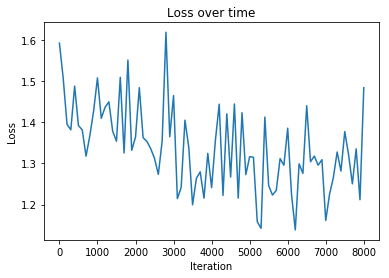

In [57]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_history))[0::100], loss_history[0::100])
fig.savefig('Loss over time (5 classes).png')

In [49]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)
print(val_hist.shape)
print(train_hist.shape)

(346, 5)
(345, 5)


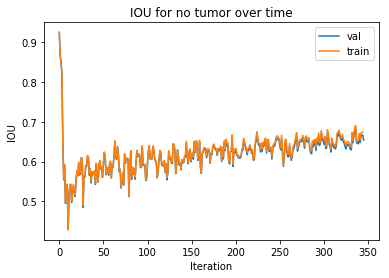

In [56]:
fig = plt.figure()
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,0], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,0], label='train')
plt.legend()
fig.savefig('IOU for no tumor (5 classes) - Poster.png')

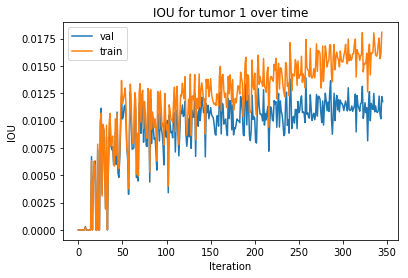

In [58]:
fig = plt.figure()
plt.title('IOU for tumor 1 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,1], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,1], label='train')
plt.legend()
fig.savefig('IOU for tumor 1 (5 classes) - Poster.png')

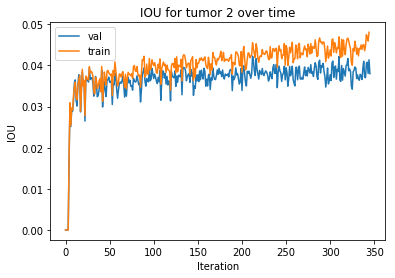

In [59]:
fig = plt.figure()
plt.title('IOU for tumor 2 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,2], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,2], label='train')
plt.legend()
fig.savefig('IOU for tumor 2 (5 classes) - Poster.png')

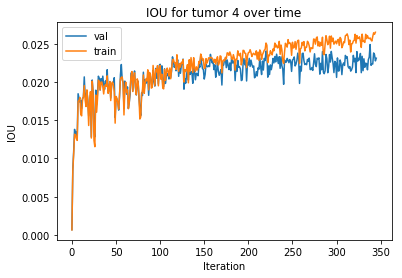

In [60]:
fig = plt.figure()
plt.title('IOU for tumor 4 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(val_hist.shape[0]), val_hist[:,4], label='val')
plt.plot(range(train_hist.shape[0]), train_hist[:,4], label='train')
plt.legend()
fig.savefig('IOU for tumor 4 (5 classes) - Poster.png')

In [61]:
check_iou(test_loader, model)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


array([0.65621317, 0.01421017, 0.04089381, 0.        , 0.02031137])